In [7]:
# =========================================================
# 1. Data Preparation
# =========================================================
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from imshow import imshow
from ImageClassifier import ImageClassifier
from MetricsCallback import MetricsCallback
from torch import nn

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Fix random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Dataset
root_dir = "data"
dataset = ImageFolder(root=root_dir, transform=transform)
class_names = dataset.classes
print(class_names)

# Train/validation split
train_size = int(0.8*len(dataset))
val_size = len(dataset)-train_size
train_dataset, val_dataset = random_split(dataset,[train_size,val_size], generator=torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Create reports folder
os.makedirs("reports/figures", exist_ok=True)

# Class distribution
counts = pd.Series([dataset.targets.count(i) for i in range(len(class_names))], index=class_names)
class_dist = pd.DataFrame({"Class":class_names, "Count":counts.values})
class_dist.to_csv("reports/class_distribution.csv", index=False)

# Image dimension summary
sizes = [Image.open(dataset.samples[i][0]).size for i in range(len(dataset))]
widths, heights = zip(*sizes)
dim_df = pd.DataFrame({"Width":widths, "Height":heights})
dim_summary = dim_df.describe().round(2)
dim_summary.to_csv("reports/image_dimensions_summary.csv")

# Train/val split summary
split_df = pd.DataFrame({"Set":["Train","Validation"], "Samples":[len(train_dataset),len(val_dataset)]})
split_df.to_csv("reports/train_validation_distribution.csv", index=False)


# =========================================================
# 2. Model Definition & Training
# =========================================================
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve



# =========================================================
# 3. Metrics Callback
# =========================================================
from pytorch_lightning.callbacks import Callback



metrics_cb = MetricsCallback()


# =========================================================
# 4. Train Model
# =========================================================
model = ImageClassifier(num_classes=len(class_names))
trainer = Trainer(max_epochs=3, accelerator="auto", deterministic=True, callbacks=[metrics_cb], num_sanity_val_steps=0)
trainer.fit(model, train_loader, val_loader)


# =========================================================
# 5. Model Evaluation
# =========================================================
all_preds, all_labels, all_probs = [],[],[]
model.eval()
with torch.no_grad():
    for x,y in val_loader:
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:,1]
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())
        all_probs.extend(probs.numpy())

cm = confusion_matrix(all_labels, all_preds)
frac_pos, mean_pred = calibration_curve(all_labels, all_probs, n_bins=8)
print()
calib_error = np.abs(frac_pos-mean_pred).mean()

# Compute per-sample loss for misclassified examples
losses, samples, labels_np, pred_probs = [], [], [], []
with torch.no_grad():
    for x,y in val_loader:
        print("Nuevo batch")
        logits = model(x)
        print("Logits: ",  logits)
        probs = torch.softmax(logits, dim=1)[:, 1]
        print("probs: ", probs)
        loss_batch = nn.CrossEntropyLoss(reduction="none")(logits,y)
        preds_batch = torch.argmax(logits, dim=1)
        mask = preds_batch != y
        print(sum(mask))
        if mask.any():
            losses.extend(loss_batch[mask].numpy())
            samples.extend(x[mask].numpy())
            labels_np.extend(y[mask].numpy())
            pred_probs.extend(probs[mask].numpy())
losses = np.array(losses)
samples = np.array(samples)
labels_np = np.array(labels_np)
pred_probs = np.array(pred_probs)

# Select top-k misclassified per class
k = 6
top_samples=[]
for c in range(len(class_names)):
    idx_class = np.where(labels_np==c)[0]
    idx_top = idx_class[np.argsort(losses[idx_class])[-(k//2):]]
    top_samples.extend(idx_top)

/home/alumno/Escritorio/Sloths/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


['pain_au_chocolat', 'sloths']


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 2.1 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.484     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/home/alumno/Escritorio/Sloths/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█| 6/6 [00:02<00:00,  2.28it/s, v_num=4, train_loss_step=0.296, tr
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 11/11 [00:00<00:00, 14.51it/s]
Epoch 1: 100%|█| 6/6 [00:02<00:00,  2.19it/s, v_num=4, train_loss_step=0.284, tr
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 11/11 [00:00<00:00, 13.78it/s]
Epoch 2: 100%|█| 6/6 [00:02<00:00,  2.37it/s, v_num=4, train_loss_step=0.319, tr
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 11/11 [00:00<00:00, 13.95it/s]
Epoch 2: 100%|█| 6/6 [00:03<

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|█| 6/6 [00:03<00:00,  1.69it/s, v_num=4, train_loss_step=0.319, tr

Nuevo batch
Logits:  tensor([[ 1.3619, -2.6890],
        [-2.2567,  3.4100],
        [-0.6952,  0.7618],
        [-1.5855,  2.3105]])
probs:  tensor([0.0171, 0.9966, 0.8111, 0.9801])
tensor(0)
Nuevo batch
Logits:  tensor([[-1.4414,  2.1348],
        [ 1.1942, -2.3166],
        [ 1.2967, -2.6291],
        [-2.3951,  3.5394]])
probs:  tensor([0.9728, 0.0290, 0.0193, 0.9974])
tensor(0)
Nuevo batch
Logits:  tensor([[-1.3263,  2.0809],
        [-1.3815,  2.1491],
        [ 1.3805, -2.6163],
        [ 0.3875, -0.8285]])
probs:  tensor([0.9679, 0.9715, 0.0180, 0.2287])
tensor(0)
Nuevo batch
Logits:  tensor([[-1.4617,  2.2379],
        [-1.9773,  3.0356],
        [ 1.6396, -3.5815],
        [ 0.8826, -1.6877]])
probs:  tensor([0.9759, 0.9934, 0.0054, 0.0711])
tensor(0)
Nuevo batch
Logits:  tensor([[-1.9911,  2.9315],
        [ 0.4936, -1.1817],
        [-0.7007,  0.8516],
        [-0.9403,  1.5102]])
probs:  tens

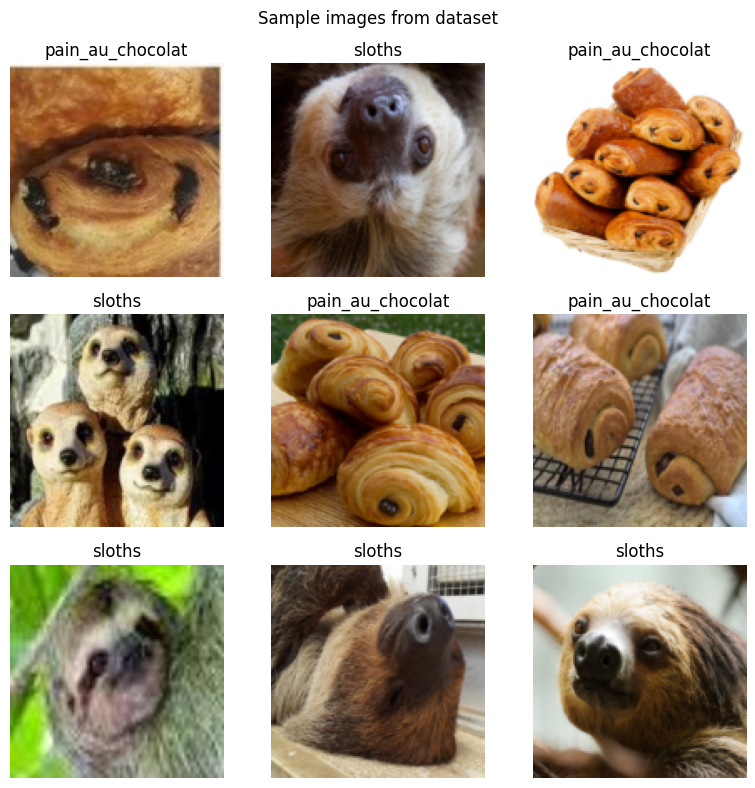

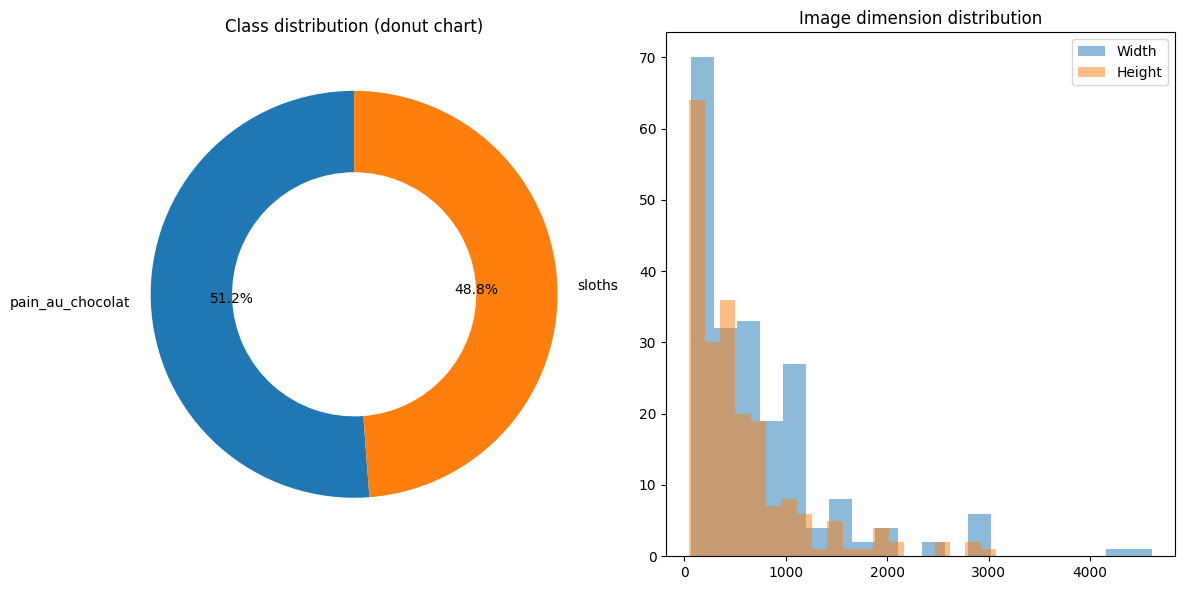

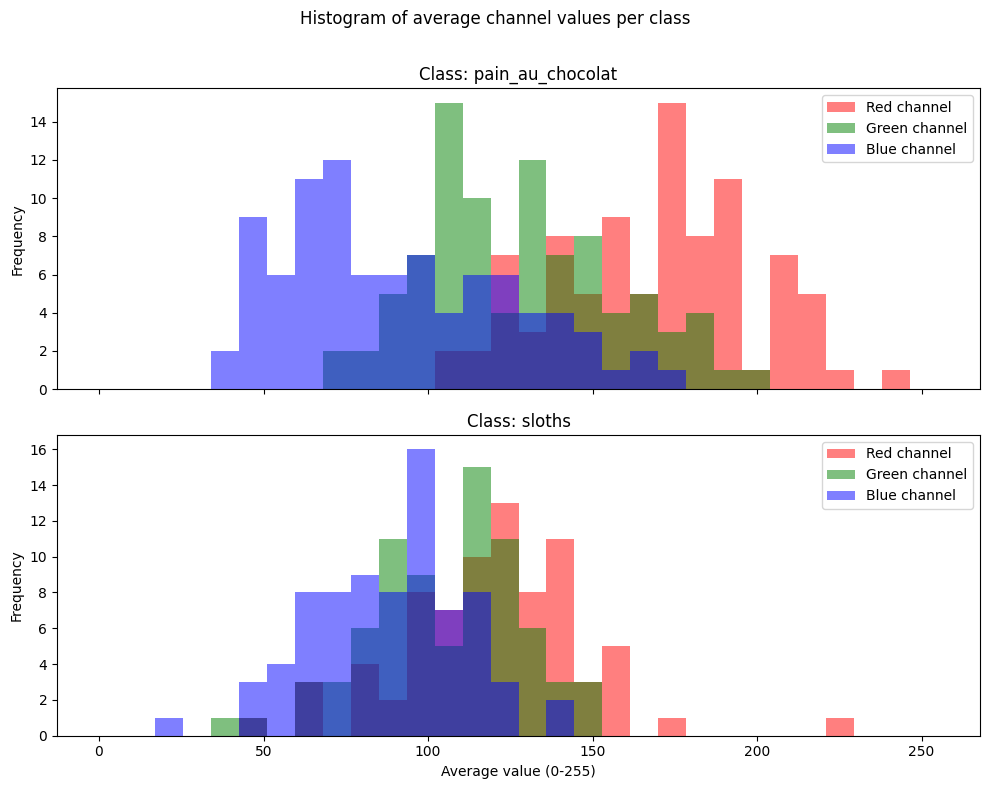

Lenght train loss:  3
[0.6087278127670288, 0.29595932364463806, 0.21589991450309753]
Lenght val loss:  3
[0.25585147738456726, 0.15689922869205475, 0.09718658775091171]


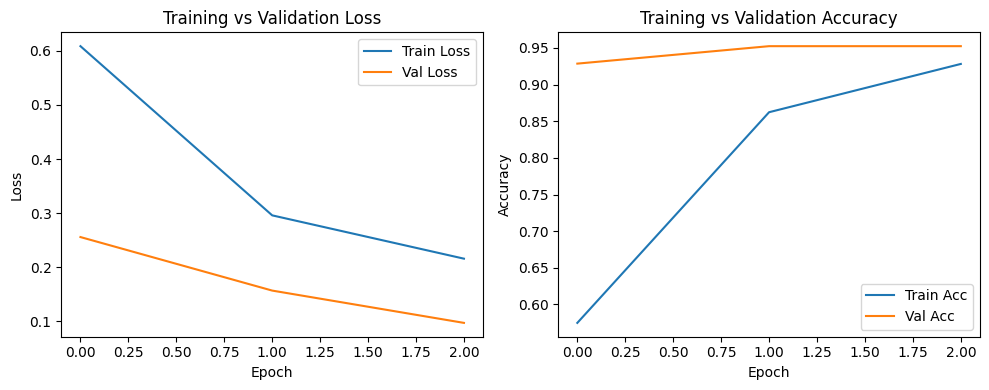

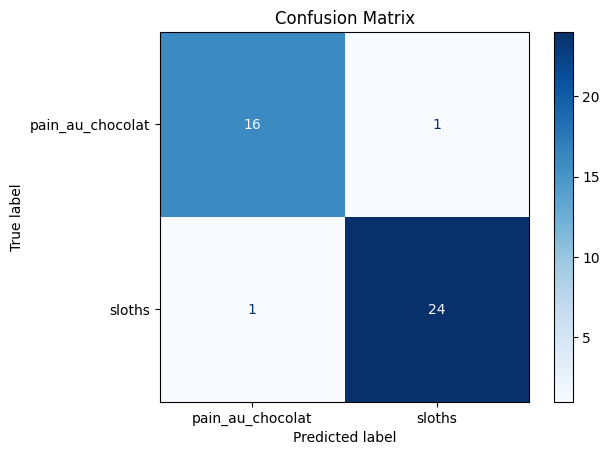

Mean prediction:  [0.02282137 0.19318631 0.52303106 0.81816265 0.97853987]
Positive fraction:  [0.  0.5 0.  1.  1. ]


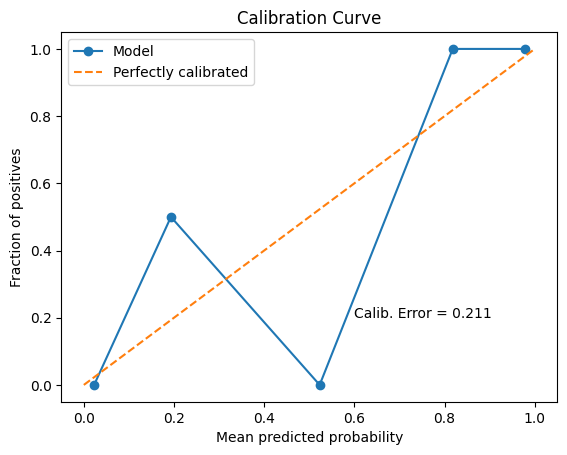

TS: [np.int64(1), np.int64(0)]


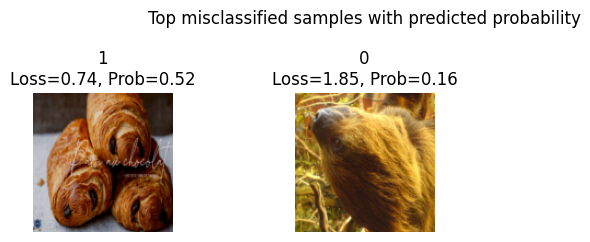

In [12]:
# =========================================================
# 6. Visualization
# =========================================================
# Sample images

images, labels = next(iter(train_loader))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(images[i], class_names[labels[i]])
plt.suptitle("Sample images from dataset")
plt.tight_layout()
plt.savefig("reports/figures/sample_images.png")
plt.show()

# =========================================================
# Class distribution (donut) + Image dimensions (bar) juntos
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].pie(
    class_dist["Count"],
    labels=class_dist["Class"],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4)
)
axes[0].set_title("Class distribution (donut chart)")

axes[1].hist(widths, bins=20, alpha=0.5, label="Width")
axes[1].hist(heights, bins=20, alpha=0.5, label="Height")
axes[1].legend()
axes[1].set_title("Image dimension distribution")

plt.tight_layout()
plt.savefig("reports/figures/class_and_dimensions.png")
plt.show()


# =========================================================
# Histograms of average R, G, B channel values per class
# =========================================================

class_avg_colors = {cls: [] for cls in range(len(class_names))}

for imgs, labels in train_loader:
    imgs = imgs * 0.5 + 0.5
    imgs = imgs * 255.0  

    batch_avg = imgs.mean(dim=[2,3])  

    for i, label in enumerate(labels):
        class_avg_colors[label.item()].append(batch_avg[i])

for cls in class_avg_colors:
    if len(class_avg_colors[cls]) > 0:
        class_avg_colors[cls] = torch.stack(class_avg_colors[cls]).numpy()
    else:
        class_avg_colors[cls] = np.zeros((0,3))

n_classes = len(class_names)
fig, axes = plt.subplots(n_classes, 1, figsize=(10, 4*n_classes), sharex=True)

if n_classes == 1:
    axes = [axes] 

colors = ["red", "green", "blue"]
labels = ["Red", "Green", "Blue"]

for cls, ax in enumerate(axes):
    data = class_avg_colors[cls]
    for i in range(3):
        ax.hist(
            data[:, i], bins=30, color=colors[i], alpha=0.5, 
            range=(0,255), label=f"{labels[i]} channel"
        )
    ax.set_title(f"Class: {class_names[cls]}")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.xlabel("Average value (0-255)")
plt.suptitle("Histogram of average channel values per class")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("reports/figures/avg_color_channels_per_class.png")
plt.show()


# =========================================================
# Training vs Validation curves
# =========================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("Lenght train loss: ", len(metrics_cb.train_loss))
print(metrics_cb.train_loss)
print("Lenght val loss: ", len(metrics_cb.val_loss))
print(metrics_cb.val_loss)
plt.plot(metrics_cb.train_loss, label="Train Loss")
plt.plot(metrics_cb.val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics_cb.train_acc, label="Train Acc")
plt.plot(metrics_cb.val_acc, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("reports/figures/training_curves.png")
plt.show()

# =========================================================
# Confusion matrix
# =========================================================
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("reports/figures/confusion_matrix.png")
plt.show()

# =========================================================
# Calibration curve
# =========================================================
print("Mean prediction: ", mean_pred)
print("Positive fraction: ", frac_pos)
plt.plot(mean_pred, frac_pos, marker="o", label="Model")
plt.plot([0,1],[0,1],linestyle="--",label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.text(0.6,0.2,f"Calib. Error = {calib_error:.3f}")
plt.savefig("reports/figures/calibration_curve.png")
plt.show()

# =========================================================
# Top misclassified samples
# =========================================================
print("TS:", top_samples)
plt.figure(figsize=(8,4))
for i, idx in enumerate(top_samples):
    plt.subplot(2,3,i+1)
    img = samples[idx]/2 + 0.5
    plt.imshow(np.transpose(img,(1,2,0)))
    #plt.title(f"{class_names[labels_np[idx]]}\nLoss={losses[idx]:.2f}, Prob={pred_probs[idx]:.2f}")
    plt.title(f"{labels_np[labels_np[idx]]}\nLoss={losses[idx]:.2f}, Prob={pred_probs[idx]:.2f}")
    plt.axis("off")
plt.suptitle("Top misclassified samples with predicted probability")
plt.tight_layout()
plt.savefig("reports/figures/high_loss_samples_with_prob.png")
plt.show()
